# Example QHMM implementation
This notebook walks demonstrates how to predict and train with the Quantum Hidden Markov Model. We demonstrate this process first using a statevector simulator, then with a sampler primitive, then finally show how to customize how the QHMM submits and recieves circuits.

## Chapter 1: Noiseless Statevector Results

### Step 1: Define Hyperparameters

All the models we look at will use the same initial state and ansatz circuits. We will also use the same parameters theta_gen and theta_train_0 for the sampling and training process.

We are going to look at models with 4 hidden states. Let's define a circuit to prepare a maximally mixed initial hidden state:

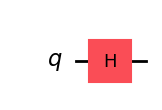

In [2]:
from qiskit import QuantumCircuit

# 2 qubits = 4 hidden states
initial_state = QuantumCircuit(1, name='Initial_State')
initial_state.h(0)
initial_state.draw('mpl')

We prepare a parameterized ansatz circuit that will be applied to the hidden and observed qubits with every time step:

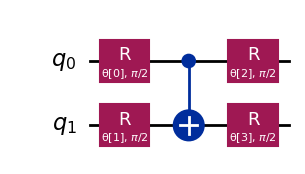

In [7]:
from qiskit.circuit.library import real_amplitudes, efficient_su2

ansatz = efficient_su2(2, reps=1, entanglement='pairwise', su2_gates=['ry'])
ansatz.decompose(reps=1).draw('mpl')

The training process parameters we need include the rotation angles we will use to generate training data (theta_gen) and  begin the training process (theta_train_0), as well as standard training prarameters like the maximum number or iterations (max_iter), length of the training sequence (sequence_length), and convergence tolerance (tol). 

The Pauli-Y rotations have a period of 4 $\pi$, so we choose starting parameters between 2 $\pi$ and 6 $\pi$. We then apply constraints to keep the parameters between 0 and 8$\pi$ throughout the training process. This allows the QHMM to take advantage of the full expresivity of the ansatz.

Because we have chosen an unparameterized initial state circuit, the number of parameters in our model is equal to the number of paramters in our ansatz circuit.

In [8]:
# Training Hyperparameters
sequence_length = 4
tol = 1e-6
max_iter = 100

In [22]:
import numpy as np

# Generating and starting parameters
num_parameters = ansatz.num_parameters

theta_gen = [np.random.uniform(2*np.pi,  6* np.pi) for _ in range(num_parameters)]
theta_0 = [4*np.pi for _ in range(num_parameters)]

### Step 2: Choose how to submit circuits
Choose our 'result_getter' strategy. This object controls how the circuit is executed. A selection of result getters are already provided in HMM.utils.qhmm_utils, or the user can create a custom result getter when executing a QHMM on a not-yet-supported platform.

We will be using the simulated result getter in this first exercise:

In [24]:
from HMM.utils.qhmm_utils import statevector_result_getter

simulator_rg = statevector_result_getter()

### Step 3: Initialize QHMM

In [25]:
from HMM import QHMM

generating_model = QHMM(result_getter=simulator_rg,
                        initial_state=initial_state,
                        ansatz=ansatz,
                        theta=theta_gen)

training_model_simulator = QHMM(result_getter=simulator_rg,
                                initial_state=initial_state,
                                ansatz=ansatz)

### Step 4: Generate Training Sequence

In [ ]:
sequence = generating_model.generate_sequence(sequence_length)

[0, 1, 0, 1]
-3.3095456809564228


### Step 5: Train Model

We use the Nelder-Mead optimization method to maximize the likelihood that the training model would produce the generated sequence.

In [8]:
from HMM.utils.qhmm_utils import minimize_qhmm

theta_trained, training_time, training_curve = minimize_qhmm(model = training_model_simulator,
              sequence=sequence,
              theta_0=theta_0,
              max_iter=max_iter,
              tol=tol)


In [9]:
print('Theta_gen: ', theta_gen)
print('Trained theta: ', theta_trained)

Theta_gen:  [10.881121426468084, 8.811627350460103, 17.30916443665576, 14.52764654430968, 7.4486102229733975, 14.0398061342805, 10.858034779511367, 18.442990481467028, 9.175401049681614, 16.330187525163282, 7.631773448232201, 12.422317280522485, 8.768337804554594, 18.020782699137776, 18.590121476180087, 15.757085552466304]
Trained theta:  [12.56165864881293, 11.941986027476425, 13.189862005836016, 13.372428586399682, 12.798461524636103, 12.707468213741446, 10.7261471330626, 12.20375866927668, 12.426988791786705, 12.932881512867816, 12.828291355942284, 13.180134554162173, 12.84725047064364, 13.066649579156618, 12.523694343307533, 12.282794165721683]


In [10]:
from scipy.stats import entropy

def generate_sequences(model, n_sequences, length):
    """Generate sequences from an HMM model."""
    sequences = []
    for _ in range(n_sequences):
        seq = model.generate_sequence(length)
        if not isinstance(seq, list):
            seq = seq.tolist()
        sequences.append(seq)
    return sequences

def calculate_kl_divergence(model1, model2, sequences):
    """Calculate the KL divergence between two HMM models using generated sequences."""
    log_prob_model1 = np.array([model1.log_likelihood(seq) for seq in sequences])
    log_prob_model2 = np.array([model2.log_likelihood(seq) for seq in sequences])
    
    # Convert log probabilities to probabilities
    prob_model1 = np.exp(log_prob_model1)
    prob_model2 = np.exp(log_prob_model2)
    
    # Normalize the probabilities to get a distribution
    prob_model1 /= prob_model1.sum()
    prob_model2 /= prob_model2.sum()
    
    # Calculate KL divergence
    kl_divergence = entropy(prob_model1, prob_model2)
    return kl_divergence

def kl_divergence_between_hmm(model1, model2, n_sequences=100, sequence_length=5):
    """
    Calculate the KL divergence between two HMM models.
    
    Parameters:
    - model1: First HMM model
    - model2: Second HMM model
    - n_sequences: Number of sequences to generate
    - sequence_length: Length of each sequence
    
    Returns:
    - kl_divergence: The KL divergence between the two models
    """
    # Generate sequences from the first model
    sequences = generate_sequences(model1, n_sequences, sequence_length)
    
    # Calculate KL divergence
    kl_divergence = calculate_kl_divergence(model1, model2, sequences)
    
    return kl_divergence

In [11]:
from HMM import PC_HMM

theta_0_c = [0.1, 0.1, 0.1]
observations = [-0.3, -0.1, 0.1, 0.3]

model_2 = PC_HMM(k=1,
                ncl=4,
                theta=theta_0_c,
                observations = observations)

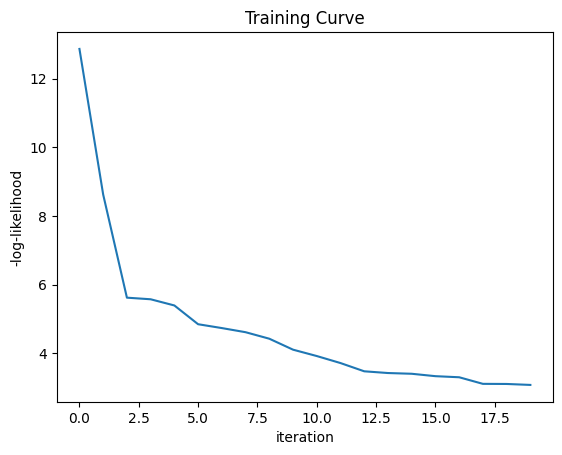

In [12]:
import matplotlib.pyplot as plt

plt.plot(training_curve)
plt.xlabel('iteration')
plt.ylabel('-log-likelihood')
plt.title('Training Curve')
plt.show()

## Chapter 2: Sampler Results

Let's see what a circuit generated by the qhmm looks like. The 100 time step circuit is a bit long, so for simplicities sake let's look at two time step circuit:

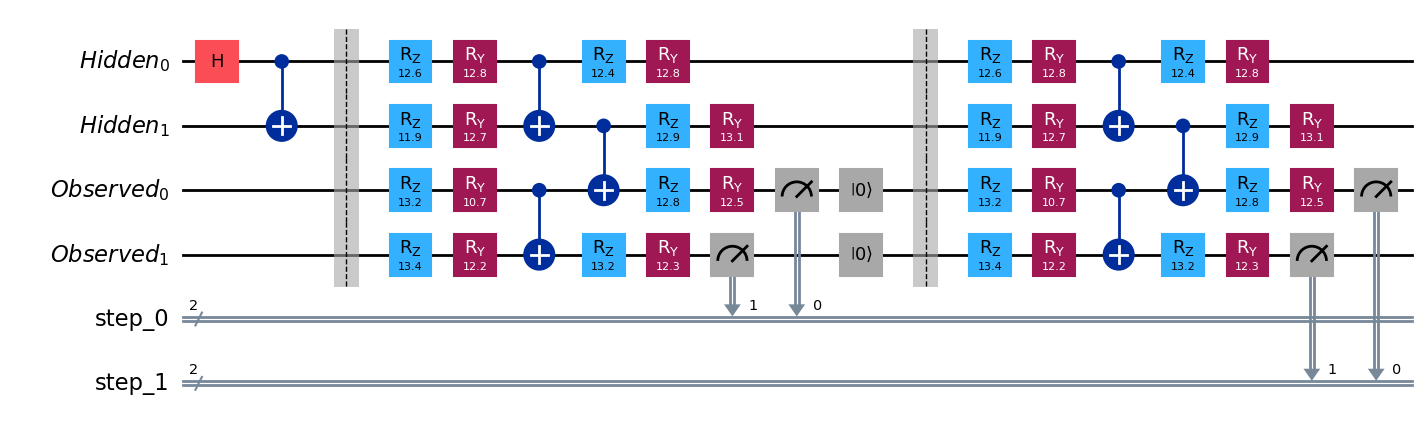

In [13]:
circuit = training_model_simulator.construct_circuit(num_time_steps=2)
circuit.decompose(reps=0).decompose().draw('mpl')

Let $d_i$ and $d_a$ be the depths of the initial state and ansatz circuits respectively. The full depth of the QHMM circuit is $d_i + (d_a \times t)$ where $t$ is the number of time steps. 

Lets transpile both circuits for ibm_torino, and see what the circuit depth would be for different numbers of time steps:

In [14]:
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeTorino

backend = FakeTorino()

d_i = transpile(initial_state, backend).depth()
d_a = transpile(ansatz, backend).depth()

print('circuit depth for 100 time steps: ', d_i + (100*d_a))
print('circuit depth for 1000 time steps: ', d_i + (1000*d_a))
print('circuit depth for 10,000 time steps: ', d_i + (10000*d_a))

circuit depth for 100 time steps:  1706
circuit depth for 1000 time steps:  17006
circuit depth for 10,000 time steps:  170006


For demonstration purposes, here is how to train a model within a qiskit-ibm-runtime session. For simplicity, we define a new set of data with only 4 time steps and limit our training process to 10 iterations.

In [15]:
'''
from qiskit_ibm_runtime import SamplerV2, Session, QiskitRuntimeService
from HMM.utils.qhmm_utils import sampler_result_getter

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False)

sequence_length=4
max_iter=10
  
sampler_sequence = generating_model.generate_sequence(length=sequence_length)


with Session(backend=backend) as session:
    sampler = SamplerV2(mode=session)
    sampler_rg = sampler_result_getter(sampler)

    training_model_sampler= QHMM(result_getter=sampler_rg,
                                initial_state=initial_state,
                                ansatz=ansatz)
    
    theta_trained, training_time, training_curve = minimize_qhmm(model = training_model_sampler,
              sequence=sampler_sequence,
              theta_0=theta_0,
              max_iter=max_iter,
              tol=tol)
'''

'\nfrom qiskit_ibm_runtime import SamplerV2, Session, QiskitRuntimeService\nfrom HMM.utils.qhmm_utils import sampler_result_getter\n\nservice = QiskitRuntimeService()\nbackend = service.least_busy(simulator=False)\n\nsequence_length=4\nmax_iter=10\n  \nsampler_sequence = generating_model.generate_sequence(length=sequence_length)\n\n\nwith Session(backend=backend) as session:\n    sampler = SamplerV2(mode=session)\n    sampler_rg = sampler_result_getter(sampler)\n\n    training_model_sampler= QHMM(result_getter=sampler_rg,\n                                initial_state=initial_state,\n                                ansatz=ansatz)\n    \n    theta_trained, training_time, training_curve = minimize_qhmm(model = training_model_sampler,\n              sequence=sampler_sequence,\n              theta_0=theta_0,\n              max_iter=max_iter,\n              tol=tol)\n'

Let's look at the training process on the FakeTorino provider:

In [16]:
from qiskit_ibm_runtime import SamplerV2
from HMM.utils.qhmm_utils import sampler_result_getter

backend = FakeTorino()

sampler = SamplerV2(mode=backend)
sampler_rg = sampler_result_getter(sampler=sampler)

sequence_length=4
max_iter=10

In [17]:
generating_model_sampler= QHMM(result_getter=sampler_rg,
                             initial_state=initial_state,
                             ansatz=ansatz,
                             theta=theta_gen)

training_model_sampler= QHMM(result_getter=sampler_rg,
                                initial_state=initial_state,
                                ansatz=ansatz)

In [18]:
sampler_sequence = generating_model_sampler.generate_sequence(length=sequence_length)

c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u0 on channel u0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u1 on channel u1 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u0 on channel u0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarn

In [19]:
theta_trained, training_time, training_curve = minimize_qhmm(model = training_model_sampler,
              sequence=sampler_sequence,
              theta_0=theta_0,
              max_iter=max_iter,
              tol=tol)

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.backend('ibm_torino')

In [21]:
print(sequence)

[0, 2, 3, 2]


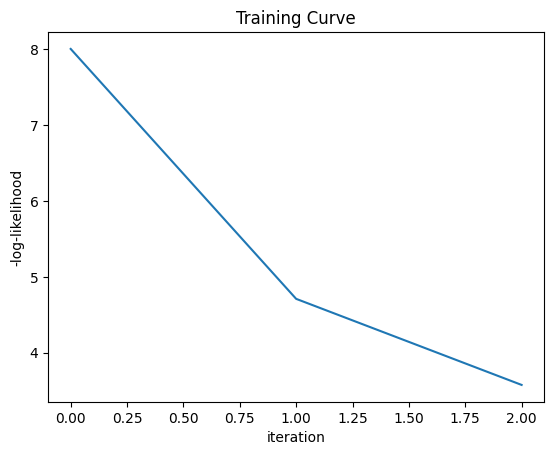

In [22]:
plt.plot(training_curve)
plt.xlabel('iteration')
plt.ylabel('-log-likelihood')
plt.title('Training Curve')
plt.show()

This final QHMM demonstration will show how to customize the circuit submittion process. This allows the user to use with new qiskit add-ons or other quantum platforms to submit and retrieve circuits, without breaking the model code.

To do this, all we have to do is create a new result_getter. Let's try a circuit 

In [23]:
from HMM.utils.qhmm_utils import result_getter
from qiskit_ibm_runtime import SamplerV2 as Sampler

class custom_result_getter(result_getter):
    def generate_sequence(self, circuit):
        super().generate_sequence()
        '''
        Insert any add-on, debug tools, or custom transpiler code here
        '''
        backend = FakeTorino()
        transpiled = transpile(circuit, backend)
        sampler = Sampler(mode=backend)
        job = sampler.run([transpiled])
        results = job.result()[0].data
        sequence = []
        for key in results.keys():
            sequence.append(int(results[key].array[0,0]))
        return sequence

custom_rg = custom_result_getter()

In [10]:
from HMM import NPC_HMM
import numpy as np

transition_matrix = np.random.rand(4, 4)

# Normalize each row so that it sums to 1
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
#theta = np.array(transition_matrix)[:,:-1].flatten().tolist()

print(theta)

hmm = NPC_HMM(theta = theta,
             k=2,
             ncl=4,
             observations=[-0.03, 0.04])

seq = hmm.generate_sequence(4)

print(seq)
print(hmm.log_likelihood(seq))

[0.10392668931818926, 0.1777037898353118, 0.32727906100729354, 0.513745720180152, 0.1410865477143382, 0.0579793078546543, 0.1355180263810542, 0.3970891427779065, 0.2021663143271303, 0.32784529019651476, 0.29523410831811664, 0.1845893473812538]
[[0]
 [1]
 [1]
 [0]]
-2.7726244318358084


In [24]:
neat_model= QHMM(result_getter=custom_rg,
                             initial_state=initial_state,
                             ansatz=ansatz,
                             theta=theta_gen)
    
seqeunce = neat_model.generate_sequence(length=sequence_length)


c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u0 on channel u0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u1 on channel u1 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction CZ90_u0 on channel u0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
c:\Users\19899\anaconda3\envs\QHMM_MLE\Lib\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarn